In [37]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Image Classification Dataset

In [2]:
mnist = fetch_openml('mnist_784',version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist['data'],mnist['target']

(-0.5, 27.5, 27.5, -0.5)

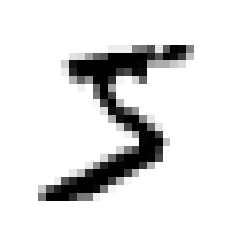

In [56]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')

In [6]:
y[0]

'5'

# Label Engineering 

In [7]:
# Cast
y = y.astype(np.uint8)

# Train/Test Split

In [8]:
# Split

X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# Binary Label for 5s

In [9]:
# 5-detector

# 1 in all instances its a 5, else 0 
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

# SGD Binary Classifier for 5s

In [10]:
# Stochastic Gradient Descent without randomness

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

# Accuracy

In [12]:
#Cross Validation
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# How many instances are actually 5 in the entire dataset
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool) # Returns all instances with 0 (not '5')

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Accuracy overrated in skewed datasets

# Confusion Matrix

In [15]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [16]:
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- Negative Row on Top & Negative Column First (TN,FN)

- Postive Row on Bottom & Negative COlumn First (TP,FP)

- Maximize TN & FP

- Precision = TP / (TP+FP)

- Recall = TP / (TP + FN)

# Precision: When it claims an image is a 5, how often is it correct


In [17]:
precision_score(y_train_5,y_train_pred)


0.8370879772350012

# Recall: How many 5's does it detect


In [18]:

recall_score(y_train_5,y_train_pred)

0.6511713705958311

# F1 Score: 2 * (Precision X Recall / Precision + Recall)


In [19]:

f1_score(y_train_5,y_train_pred)

0.7325171197343846

- High Precision when classifying videos for kids
- High Recall when detecting shoplifters

- Precision/Recall trade off depends on threshold
    - If threshold low: Higher Recall, Lower Precision
    - If threshild high: Lower Recall, Higher Precision
   

# Adjusting Threshold 

In [20]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method = 'decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)


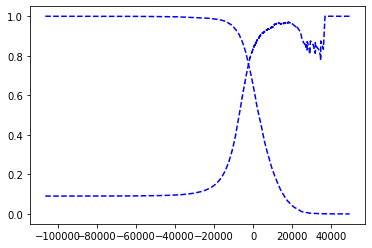

In [21]:
def plot_precision_recall_curve(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="precision")
    plt.plot(thresholds,recalls[:-1],"b--",label="recall")
    
plot_precision_recall_curve(precisions,recalls,thresholds)

# 90% Precision?

In [22]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]
threshold_90_precision

y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5,y_train_pred_90)
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

# ROC Curve: FP rate vs TP rate

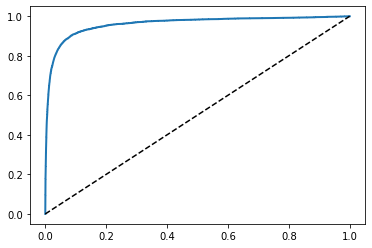

In [23]:
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')

plot_roc_curve(fpr,tpr)

# AUC under ROC: Closer to 1 the better

In [24]:
roc_auc_score(y_train_5,y_scores)


0.9604938554008616

- Use PR curve when positive class is small or false positive is worse than false negative 
- Use ROC otherswise

# Compare Random Forest to SGD via ROC Curve

In [25]:
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

/Users/ayusharora/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ayusharora/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ayusharora/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [26]:
y_scores_forest = y_probas_forest[:,-1]
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)

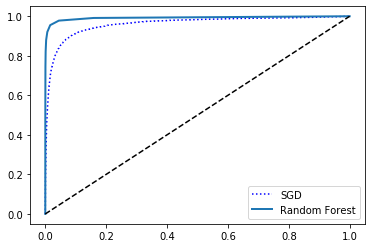

In [27]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")

In [28]:
roc_auc_score(y_train_5,y_scores_forest)

0.9920527492698306

In [29]:
# Precision & Recall
y_train_pred_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3)



/Users/ayusharora/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ayusharora/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ayusharora/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [30]:
precision_score(y_train_5,y_train_pred_forest)


0.986046511627907

In [31]:
recall_score(y_train_5,y_train_pred_forest)


0.8212506917542889

- Random Forest is far better Precision/Recall/ROC wise

# Multiclass Classification

- LR & SVM are strictly binary
    - However, One vs All strategy can turn these into MultiClass Classification (LR & rest ideal)
    - One vs One would need many classifers as it would compare each label with every other label (SVM ideal)

In [ ]:
# SVM with One vs All
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

In [ ]:
# SGD 
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

In [ ]:
# RF
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

In [ ]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [ ]:
# Cross Validation Check for SGD
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

In [ ]:
# Cross Validation Check for RF
cross_val_score(forest_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

In [ ]:
# Error Analysis

y_train_pred = cross_val_score(forest_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)

In [ ]:
# Digits are being misclassified as 8, but actual 8s are being correctly classified 

In [39]:
# Multilabel Classification
# Use KNeighborsClassifier to output multiple label predictions for each instance 
# Ex: multiple label: [(whether digit is >7, whether digit is odd)] 
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [52]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
# Multioutput Classification
# Use KNeighborsClassifier to output multiclass pixel predictions for each instance (instead of only T/F, more possible)

# create noise for train and test data
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise

In [54]:
# assign clean data as labels for train and test data
y_train_mod = X_train
y_test_mod = X_test

In [60]:
def plot_digit(digit):
    some_digit_image = digit.reshape(28,28)

    plt.imshow(some_digit_image,cmap='binary')
    plt.axis('off')

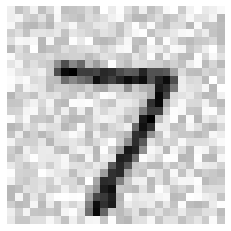

In [62]:
# Train Model to translate noisy to clean 
knn_clf.fit(X_train_mod,y_train_mod)
plot_digit(X_test_mod[0])

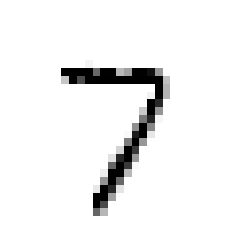

In [63]:
# Test model on noisy digit pictured above
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)